In [65]:
# Data Manipulation and Analysis
import numpy as np
import pandas as pd

# Statistical Modeling and Mathematics
import statsmodels.api as sm  
from math import sqrt
import scipy.stats as stats

# Data Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go

# Data Encoding and Preprocessing
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

# Modeling and Machine Learning
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor
from statsmodels.tsa.arima.model import ARIMA
#from fbprophet import Prophet


# Metrics and Evaluation
from sklearn.datasets import make_regression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error, mean_squared_log_error, mean_absolute_percentage_error,make_scorer

# Optimization
from sklearn.model_selection import GridSearchCV

# Other
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# Import libraries

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import SGDRegressor
from xgboost import XGBRegressor

# Model selection and evaluation
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV

In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
stores = pd.read_csv("stores.csv")
oil = pd.read_csv("oil.csv")
holidays = pd.read_csv("holidays_events.csv")
transactions = pd.read_csv("transactions.csv")
sample = pd.read_csv("sample_submission.csv")

# Convert date columns to datetime objects

In [3]:
train['date'] = pd.to_datetime(train['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays['date'] = pd.to_datetime(holidays['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
test['date'] = pd.to_datetime(test['date'])

# Merge datasets on common columns

In [4]:
merged_data1 = pd.merge(train, transactions, on=['date','store_nbr'])
merged_data2 = pd.merge(merged_data1,holidays, on='date')
merged_data3 = pd.merge(merged_data2,oil, on='date')
merged_data_final = pd.merge(merged_data3,stores, on='store_nbr')


# Preview the merged data
merged_data_final.head()

,id,date,store_nbr,family,sales,onpromotion,transactions,type_x,locale,locale_name,description,transferred,dcoilwtico,city,state,type_y,cluster
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Salinas,Santa Elena,D,1
1,562,2013-01-01,25,BABY CARE,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Salinas,Santa Elena,D,1
2,563,2013-01-01,25,BEAUTY,2.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Salinas,Santa Elena,D,1
3,564,2013-01-01,25,BEVERAGES,810.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Salinas,Santa Elena,D,1
4,565,2013-01-01,25,BOOKS,0.0,0,770,Holiday,National,Ecuador,Primer dia del ano,False,NaN,Salinas,Santa Elena,D,1


In [5]:
# Rename columns using the rename method
merged_data = merged_data_final.rename(columns={"type_x": "holiday_type", "type_y": "store_type"})

In [6]:
merged_data.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 322047 entries, 0 to 322046
Data columns (total 17 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   id            322047 non-null  int64         
 1   date          322047 non-null  datetime64[ns]
 2   store_nbr     322047 non-null  int64         
 3   family        322047 non-null  object        
 4   sales         322047 non-null  float64       
 5   onpromotion   322047 non-null  int64         
 6   transactions  322047 non-null  int64         
 7   holiday_type  322047 non-null  object        
 8   locale        322047 non-null  object        
 9   locale_name   322047 non-null  object        
 10  description   322047 non-null  object        
 11  transferred   322047 non-null  bool          
 12  dcoilwtico    300003 non-null  float64       
 13  city          322047 non-null  object        
 14  state         322047 non-null  object        
 15  store_type    322

In [7]:
# Inspect data for null values
merged_data.isnull().sum()

id                  0
date                0
store_nbr           0
family              0
sales               0
onpromotion         0
transactions        0
holiday_type        0
locale              0
locale_name         0
description         0
transferred         0
dcoilwtico      22044
city                0
state               0
store_type          0
cluster             0
dtype: int64

In [8]:
# Convert dataset to CSV 
merged_data.to_csv('merged_data.csv', index=False)

In [9]:
print(merged_data.dcoilwtico.isnull().sum())

22044


# Impute the oil Missing values Using Interpolation

In [10]:
# Resample oil data by day and sum the values
oil = oil.set_index("date").dcoilwtico.resample("D").sum().reset_index()


# Interpolate missing values
merged_data["dcoilwtico"] = np.where(merged_data["dcoilwtico"] == 0, np.nan, merged_data["dcoilwtico"])
merged_data["dcoilwtico"] = oil.dcoilwtico.interpolate(method="bfill")

# Assign interpolated oil values to merged_data
merged_data["dcoilwtico"] = merged_data["date"].map(oil.set_index("date")["dcoilwtico"])

In [11]:
merged_data.isnull().sum().any()

False

# Feature Engineering; Extract Feature

In [12]:
# Change date datatype to datetime
merged_data['date'] = pd.to_datetime(merged_data['date'])

# Create new features
merged_data['year'] = merged_data['date'].dt.year
merged_data['month'] = merged_data['date'].dt.month
merged_data['dayofmonth'] = merged_data['date'].dt.day
merged_data['dayofweek'] = merged_data['date'].dt.dayofweek
merged_data['dayname'] = merged_data['date'].dt.strftime('%A')

In [13]:
merged_data.head(2)

,id,date,store_nbr,family,sales,onpromotion,transactions,holiday_type,locale,locale_name,...,dcoilwtico,city,state,store_type,cluster,year,month,dayofmonth,dayofweek,dayname
0,561,2013-01-01,25,AUTOMOTIVE,0.0,0,770,Holiday,National,Ecuador,...,0.0,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday
1,562,2013-01-01,25,BABY CARE,0.0,0,770,Holiday,National,Ecuador,...,0.0,Salinas,Santa Elena,D,1,2013,1,1,1,Tuesday


In [14]:
# Write the DataFrame to a CSV file
merged_data.to_csv('merged_data.csv', index=False)

# Pre_Processing

In [15]:
#drop unnecessary columns
merged_data.drop(columns=['id','locale', 'locale_name', 'description', 'transferred','state','store_type','dayname']
                 ,axis=1, inplace=True)

In [16]:
# set the date column as the index
merged_data.set_index('date', inplace=True)

In [17]:
merged_data.sample(3,random_state=0)

,store_nbr,family,sales,onpromotion,transactions,holiday_type,dcoilwtico,city,cluster,year,month,dayofmonth,dayofweek
date,,,,,,,,,,,,,
2016-05-12,20,PET SUPPLIES,1.000,0,1399,Event,46.64,Quito,6,2016,5,12,3
2016-04-27,46,FROZEN FOODS,203.789,5,2783,Event,45.29,Quito,14,2016,4,27,2
2016-06-23,26,HOME AND KITCHEN II,0.000,0,451,Holiday,49.34,Guayaquil,10,2016,6,23,3


In [18]:
merged_data.shape    

(322047, 13)

# Encoding

In [19]:
# Select the categorical columns
categorical_columns = ["family", "city", "holiday_type"]
categorical_data = merged_data[categorical_columns]
categorical_data

,family,city,holiday_type
date,,,
2013-01-01,AUTOMOTIVE,Salinas,Holiday
2013-01-01,BABY CARE,Salinas,Holiday
2013-01-01,BEAUTY,Salinas,Holiday
2013-01-01,BEVERAGES,Salinas,Holiday
2013-01-01,BOOKS,Salinas,Holiday
...,...,...,...
2017-08-15,POULTRY,Manta,Holiday
2017-08-15,PREPARED FOODS,Manta,Holiday
2017-08-15,PRODUCE,Manta,Holiday


In [20]:
encoder = OneHotEncoder()

# Fit and transform the data to one hot encoding
one_hot_encoded_data = encoder.fit_transform(categorical_data)
one_hot_encoded_data

<322047x60 sparse matrix of type '<class 'numpy.float64'>'
	with 966141 stored elements in Compressed Sparse Row format>

In [21]:
# Get the categories for each column
categories = [encoder.categories_[i] for i in range(len(encoder.categories_))]

# Create the column names for the one hot encoded data
column_names = []
for i in range(len(categories)):
    for j in range(len(categories[i])):
        column_names.append(f'{categorical_columns[i]}_{categories[i][j]}')

In [22]:
# Convert the one hot encoding data to a DataFrame
one_hot_encoded_data = pd.DataFrame(one_hot_encoded_data.toarray(), columns=column_names)
one_hot_encoded_data

,family_AUTOMOTIVE,family_BABY CARE,family_BEAUTY,family_BEVERAGES,family_BOOKS,family_BREAD/BAKERY,family_CELEBRATION,family_CLEANING,family_DAIRY,family_DELI,...,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
322042,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
322043,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
322044,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
322045,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [24]:
# Reset the index of both dataframes
merged_data = merged_data.reset_index(drop=True)
one_hot_encoded_data = one_hot_encoded_data.reset_index(drop=True)

# Concatenate the original dataframe with the one hot encoded data

In [25]:
merged_data_encoded = pd.concat([merged_data, one_hot_encoded_data], axis=1)

# Drop the original categorical columns
merged_data_encoded.drop(categorical_columns, axis=1, inplace=True)

In [26]:
df = merged_data_encoded.copy()

In [27]:
df.head(3)

,store_nbr,sales,onpromotion,transactions,dcoilwtico,cluster,year,month,dayofmonth,dayofweek,...,city_Quevedo,city_Quito,city_Riobamba,city_Salinas,city_Santo Domingo,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer
0,25,0.0,0,770,0.0,1,2013,1,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,25,0.0,0,770,0.0,1,2013,1,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,25,2.0,0,770,0.0,1,2013,1,1,1,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


# Perform feature scaling

In [28]:
scaler = StandardScaler()

# select numerical columns
num_cols = ['sales', 'transactions', 'dcoilwtico']

# fit and transform the numerical columns
df[num_cols] = scaler.fit_transform(df[num_cols])

In [29]:
df.columns

Index(['store_nbr', 'sales', 'onpromotion', 'transactions', 'dcoilwtico',
       'cluster', 'year', 'month', 'dayofmonth', 'dayofweek',
       'family_AUTOMOTIVE', 'family_BABY CARE', 'family_BEAUTY',
       'family_BEVERAGES', 'family_BOOKS', 'family_BREAD/BAKERY',
       'family_CELEBRATION', 'family_CLEANING', 'family_DAIRY', 'family_DELI',
       'family_EGGS', 'family_FROZEN FOODS', 'family_GROCERY I',
       'family_GROCERY II', 'family_HARDWARE', 'family_HOME AND KITCHEN I',
       'family_HOME AND KITCHEN II', 'family_HOME APPLIANCES',
       'family_HOME CARE', 'family_LADIESWEAR', 'family_LAWN AND GARDEN',
       'family_LINGERIE', 'family_LIQUOR,WINE,BEER', 'family_MAGAZINES',
       'family_MEATS', 'family_PERSONAL CARE', 'family_PET SUPPLIES',
       'family_PLAYERS AND ELECTRONICS', 'family_POULTRY',
       'family_PREPARED FOODS', 'family_PRODUCE',
       'family_SCHOOL AND OFFICE SUPPLIES', 'family_SEAFOOD', 'city_Ambato',
       'city_Babahoyo', 'city_Cayambe', 'city_C

In [30]:
missing_values = df.isnull().any()
missing_values

store_nbr                  False
sales                      False
onpromotion                False
transactions               False
dcoilwtico                 False
                           ...  
holiday_type_Additional    False
holiday_type_Bridge        False
holiday_type_Event         False
holiday_type_Holiday       False
holiday_type_Transfer      False
Length: 70, dtype: bool

# Hypothesis testing (A/B)on Earthquake

- H0: The earthquake did not have an impact on sales.No significant diff between the average sales before & after the earthquake.


- H1: The earthquake had an impact on sales.A significant difference between the average sales before and after the earthquake.

In [31]:
before_earthquake = train[train['date'] < pd.to_datetime('2016-04-16')]  
after_earthquake = train[(train['date'] >= pd.to_datetime('2016-04-16')) & (train['date'] < pd.to_datetime('2016-06-16'))]

In [32]:
group_a = before_earthquake['sales']# Sales data before the earthquake   # Group A data (control_sales)
group_b = after_earthquake['sales'] # Sales data after the earthquake   # Group B data  (experimental_sales)

In [33]:
# Calculate means and variances
mean_a = np.mean(group_a)
mean_b = np.mean(group_b)
var_a = np.var(group_a)
var_b = np.var(group_b)

In [34]:
# Perform t-test
t_stat, p_value = stats.ttest_ind(group_a, group_b)

In [35]:
# Print results
print("Group A:")
print("Mean:", mean_a)
print("Variance:", var_a)
print()
print("Group B:")
print("Mean:", mean_b)
print("Variance:", var_b)
print()
print("T-statistic:", t_stat)
print("P-value:", p_value)

Group A:
Mean: 314.68687140645835
Variance: 974352.5936017728

Group B:
Mean: 462.10053475390697
Variance: 2069558.5316440917

T-statistic: -46.77336024005001
P-value: 0.0


In [36]:
# Compare the p-value to the significance level

significance_level = 0.05

if p_value < significance_level:
    print("Reject the null hypothesis. The earthquake had a significant impact on sales.")
else:
    print("Fail to reject the null hypothesis. No significant difference in sales before and after the earthquake.")

Reject the null hypothesis. The earthquake had a significant impact on sales.


# Define X,y and Split data

In [37]:
# Create the feature dataframe using the selected columns
X = df.drop(["sales"], axis=1)

# Get the target variable
y = df.sales

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Building

## Linear Regression Model

In [38]:
lr = LinearRegression()
lr.fit(X_train, y_train)

# Make prediction on X_test
lr_predictions = lr.predict(X_test)

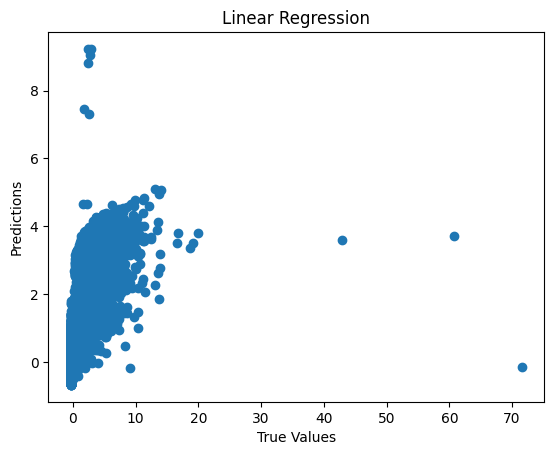

In [39]:
plt.scatter(y_test, lr_predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Linear Regression")
plt.show()

In [40]:
# Evaluation Metrics for Linear Regression
lr_mse = mean_squared_error(y_test, lr_predictions).round(2)
lr_rmse = np.sqrt(lr_mse).round(2)

In [41]:
# apply the absolute value function to y_test to remove negative signs
y_test_abs = abs(y_test)
lr_predictions_abs = abs(lr_predictions)

In [ ]:
# calculate the mean squared logarithmic error using the new y_test_abs and lr_predictions_abs array
#lr_rmsle = np.sqrt(mean_squared_log_error(y_test_abs, lr_predictions_abs)).round(2)

In [42]:
# Print the evaluation results for Linear Regression model
print("\nEvaluation Results for Linear Regression:")
print("MSE:", lr_mse)
print("RMSE:", lr_rmse)
#print("RMSLE:", lr_rmsle)


Evaluation Results for Linear Regression:
MSE: 0.48
RMSE: 0.69


# Linear Regression with hypertuned parameters

In [45]:
# Create the LinearRegression model
lr2 = LinearRegression()

# Define the hyperparameters and their ranges
param_grid = {
    'fit_intercept': [True, False], 'normalize': [True, False],'copy_X': [True, False],'n_jobs': [-1]}  


# Perform grid search with cross-validation
scorer = make_scorer(mean_squared_error, greater_is_better=False)
grid_search = GridSearchCV(lr2, param_grid, cv=5, scoring=scorer)
grid_search.fit(X_train, y_train)

# Get the best hyperparameters and their corresponding score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

# Create a new model with the best hyperparameters
lr2_best = LinearRegression(**best_params)
lr2_best.fit(X_train, y_train)

# Make predictions on the test data
y_pred = lr2_best.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
#rmsle = np.sqrt(mean_squared_log_error(y_test, y_pred))

print("Best Hyperparameters:", best_params)
print("Best Score:", best_score)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
#print("Root Mean Squared Log Error (RMSLE):", rmsle)

Best Hyperparameters: {'copy_X': True, 'fit_intercept': True, 'n_jobs': -1, 'normalize': False}
Best Score: -0.42341181149755097
Mean Squared Error (MSE): 0.4788189370874959
Root Mean Squared Error (RMSE): 0.6919674393260826


#  Ridge Regression with Hypertuned the parameters

- Since it's more likely to have autocorrelation or multicollinearity in time series, it's good to use Ridge Regression instead of OLS.


- Because OLS assumes that the observation is independent, which is not true in time series.


- By adding a penalty to the loss function, Ridge Regression shrinks the coefficients toward zero, which lead to a more stable and accurate model.

In [46]:
# Alpha controls the amount of regularization that applied to the coefficients. 
param_grid = {
    'alpha': [0.01, 0.1, 1.0, 10.0, 100.0],  # Expanded range of alpha values
}

# Create the Ridge model
ridge = Ridge()

# Perform grid search with cross-validation
grid_search = GridSearchCV(ridge, param_grid, cv=10, scoring='neg_mean_squared_error') #grid search-> highest negative MSE 
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_alpha = grid_search.best_params_['alpha']

# Create a new model with the best hyperparameters
ridge_best = Ridge(alpha=best_alpha)
ridge_best.fit(X_train, y_train)

# Make predictions on X_test using the best model
ridge_predictions = ridge_best.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, ridge_predictions)
rmse = np.sqrt(mse)
#rmsle = np.sqrt(mean_squared_log_error(y_test, ridge_predictions))

print("Best Alpha:", best_alpha)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
#print("Root Mean Squared Log Error (RMSLE):", rmsle)


Best Alpha: 1.0
Mean Squared Error (MSE): 0.4788171966433155
Root Mean Squared Error (RMSE): 0.6919661817193926


# XGBoost Model

In [47]:
xgb = XGBRegressor()
xgb.fit(X_train, y_train)
xgb_predictions = xgb.predict(X_test)

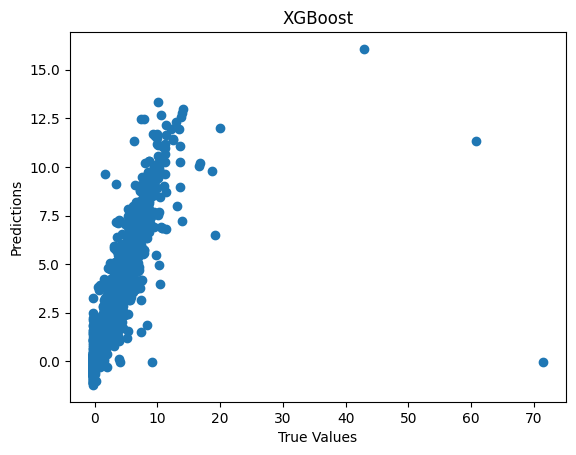

In [48]:
plt.scatter(y_test, xgb_predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("XGBoost")
plt.show()

In [49]:
# Evaluation Metrics for XGBoost
xgb_mse = mean_squared_error(y_test, xgb_predictions).round(2)
xgb_rmse = np.sqrt(xgb_mse).round(2)

In [50]:
# Print the evaluation results for XGBoost model
print("\nEvaluation Results for XGBoost:")
print("MSE:", xgb_mse)
print("RMSE:", xgb_rmse)


Evaluation Results for XGBoost:
MSE: 0.18
RMSE: 0.42


# XGBoost Model with hypertuned parameters

In [52]:
model = XGBRegressor()

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'n_estimators': [200, 300],  # Adjust the number of estimators
    'max_depth': [3, 6],           # Experiment with different depth values
    'learning_rate': [0.1, 0.01],  # Experiment with different learning rates
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(model, param_grid, cv=4, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_

# Create a new model with the best hyperparameters
model_best = XGBRegressor(**best_params)
model_best.fit(X_train, y_train)

# Make predictions
predictions = model_best.predict(X_test)

# Calculate the mean squared error and root mean squared error
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)

print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

KeyboardInterrupt: 

# Arima(AutoRegressive Integrated Moving Average)

- Combine autoregressive (AR), differencing (I), and moving average (MA) components to capture the temporal dependencies and patterns in the data. 


- ARIMA models are based on the assumption that the future values of a time series can be predicted by its past values and the residuals.


- AR componenet (p) capture relationship between the current observation and a certain number of lagged observations

- I component(d) subtracting each observation from previous observation

- The MA (q) compoenent model the relationship between current observation and the residual error from previous observation


- In general not useful for non-stationary (trend, seasolality,...) data or complex pattern

- The y_train used to fit the ARIMA model. the y_train represent the historical data. on which the model will be trained.

- And then using the y_train data, fit the model to predict the parameters


In [53]:
start=len(y_train)
start

257637

In [54]:
end=len(y_train) + len(y_test) - 1
end

322046

In [55]:
# Define the ARIMA model
# The order represents the autoregressive (AR), differencing (I), and moving average (MA) components of the model.
# (p,d,q) 2most recent observation, 0no differencing applied to time series, 0 No moving average comp is included in the model
model_ar = ARIMA(y_train, order=(2, 0, 0)) 

# Fit the ARIMA model
model_ar = model_ar.fit()

# Make predictions
predictions_ar = model_ar.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# Calculate the mean squared error
mse_ar = mean_squared_error(y_test, predictions_ar)
rmse_ar = np.sqrt(mse_ar)

# Print the MSE and RMSE
print("Mean Squared Error (MSE):", mse_ar)
print("Root Mean Squared Error (RMSE):", rmse_ar)


Mean Squared Error (MSE): 1.0339193045531494
Root Mean Squared Error (RMSE): 1.0168182259151088


- the squared difference between the predicted and actual values is 1.0339.

- the predicted values deviate from the actual values by approximately 1.0168 units

# Prophet Model

In [70]:
import pandas as pd
from fbprophet import Prophet

# Assuming your train_data DataFrame has a column named 'ds' for dates
train_data['ds'] = pd.to_datetime(train_data['ds'])

# Create a DataFrame for the test data
test_data = pd.DataFrame({'ds': X_test.index})

# Create and fit the Prophet model
model_prophet = Prophet()
model_prophet.fit(train_data)

# Generate future dates for prediction
future_dates = model_prophet.make_future_dataframe(periods=len(test_data))

# Make predictions
predictions_prophet = model_prophet.predict(future_dates[len(train_data):])

# Extract the predicted values
y_pred_prophet = predictions_prophet['yhat'].values

# Calculate the mean squared error
mse_prophet = mean_squared_error(y_test, y_pred_prophet)
rmse_prophet = np.sqrt(mse_prophet)

# Print the MSE and RMSE
print("Mean Squared Error (MSE):", mse_prophet)
print("Root Mean Squared Error (RMSE):", rmse_prophet)


ModuleNotFoundError: No module named 'fbprophet'

# Random Forest 

In [66]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make prediction on X_test
rf_predictions = rf.predict(X_test)

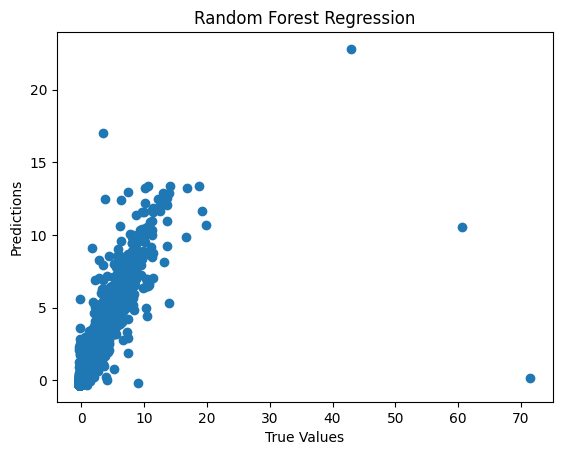

In [67]:
plt.scatter(y_test, rf_predictions)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Random Forest Regression")
plt.show()

In [68]:
# evaluation metrics for Random Forest Regression

rf_mse = mean_squared_error(y_test,rf_predictions).round(2)
rf_rmse = np.sqrt(rf_mse)

In [69]:
# Print the evaluation results for Random Forest Regrression model
print("\nEvaluation Results for Random Forest:")
print("MSE:", rf_mse)
print("RMSE:", rf_rmse)


Evaluation Results for Random Forest:
MSE: 0.17
RMSE: 0.41231056256176607


# Random Forest with Hypertuned the parameters

In [ ]:
%%time

param_grid = {
    'n_estimators': [200, 300],  # Nr of trees in the forest
    'max_depth': [ 5, 10],  # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],  # Minimum nr of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]  # Minimum nr of samples required to be at a leaf node
}

rf1 = RandomForestRegressor(random_state=42)

grid_search = GridSearchCV(rf1, param_grid, cv=5, scoring='neg_mean_squared_error') # again consider the highest negative value
grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_   


rf_best = RandomForestRegressor(**best_params, random_state=42) #Create a new model with the best hyperparameters:
rf_best.fit(X_train, y_train)

rf_predictions = rf_best.predict(X_test)  # Make predictions on X_test using the best model:

mse = mean_squared_error(y_test, rf_predictions)
rmse = np.sqrt(mse)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

# Define the ARIMA model
model_arima = ARIMA(y_train, order=(2, 1, 1))  # Example order, adjust as needed

# Fit the ARIMA model
model_arima_fit = model_arima.fit()

# Make predictions
predictions_arima = model_arima_fit.predict(start=len(y_train), end=len(y_train) + len(y_test) - 1)

# Calculate the mean squared error
mse_arima = mean_squared_error(y_test, predictions_arima)
rmse_arima = np.sqrt(mse_arima)

print("Mean Squared Error (MSE):", mse_arima)
print("Root Mean Squared Error (RMSE):", rmse_arima)


In [ ]:

# Create a table to compare the evaluation results
results_table = pd.DataFrame({'Model': ['Linear Regression', 'Decision Tree', 'XGBoost', 'Random Forest'],
                              'MSE': [lr_mse, dt_mse, xgb_mse, rf_mse],
                              'RMSE': [lr_rmse, dt_rmse, xgb_rmse, rf_rmse],
                              'RMSLE': [lr_rmsle, dt_rmsle, xgb_rmsle, rf_rmsle]})

# Print the comparison table
print("\nComparison Table of Evaluation Results:")
print(results_table)

- we Try Different Modeles, linear one like Linear Regression, Ridge Regression. 
- we also experiment with non-linear models like , random forests and  gradient boosting algorithms
- Arima and prophet model
- As the results, 